## Introduction

In [188]:
# importing useful libraries

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
#from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2, mean_squared_error as mse
from sklearn.utils import resample
import pandas as pd
import time
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from imageio import imread
import seaborn as sb

rseed = 10

### Functions

In [2]:
#defining the Franke function

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4

In [120]:
def point_generator(num_points, var, rseed):

    np.random.seed(rseed)
    points = np.random.rand(num_points,2)
    z = (FrankeFunction(points[:,0], points[:,1]) + np.random.normal(0,var,[1,num_points])).T

    return points, z

In [20]:
# this function returns the MSE, bias and variance for the data in input

def bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps):

    z_pred = np.empty((len(z_test), n_boostraps))
    for i in range(n_boostraps):
        data_, z_ = resample(data_train, z_train)
        model.fit(data_,z_)
        z_pred[:,i] = np.squeeze(model.predict(data_test)).T

    error = np.mean( np.mean((z_test - z_pred)**2, axis=1, keepdims=True) )
    bias = np.mean( (z_test - np.mean(z_pred, axis=1, keepdims=True))**2 )
    variance = np.mean( np.var(z_pred, axis=1, keepdims=True) )

    return error, bias, variance

In [68]:
# cross validation given the data and number of folds k

def cv_mse(data, z, k, model):

  df = pd.DataFrame(data)
  df["z"] = np.squeeze(z)

  df_splits = np.array_split(df, k)

  MSE = []

  for i in range(k):
    data_test = df_splits[i]
    data_train = pd.concat([df_splits[j] for j in range(k) if j!=i])

    x_train = data_train.drop(["z"],axis=1)
    x_test = data_test.drop(["z"],axis=1)
    z_train = data_train["z"]
    z_test = data_test["z"]

    reg = model.fit(x_train,z_train)
    MSE.append(mse(z_test,reg.predict(x_test)))

  return sum(MSE)/k

In [86]:
# returns the coefficients and the prediction for the test data for ridge regression

def ridge_pred(data_train,data_test,z_train,lam):

    # the coefficients are obtained through the matrix inversion formula
    beta = np.linalg.inv(data_train.T @ data_train+lam*np.eye(np.shape(data_train)[1])) @ data_train.T @ z_train

    return data_test @ beta , np.squeeze(beta)

In [67]:
# performs min-max scaling on the data

def min_max_scaling(x):
    return (x-min(x))/(max(x)-min(x))

## Franke function

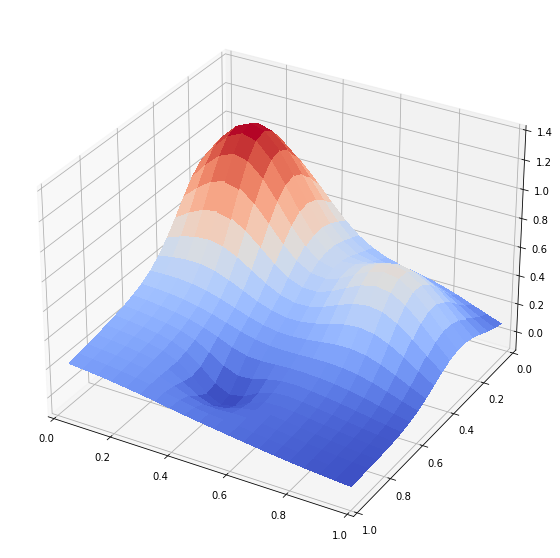

In [5]:
#plotting the surface of the Franke function with x and y in [0,1]

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")
x = np.arange(1, 0, -0.05)
y = np.arange(1, 0, -0.05)
x, y = np.meshgrid(x,y)
z = FrankeFunction(x, y)

surf = ax.plot_surface(x,y,z, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.set_xlim(0,1)
ax.set_ylim(1,0)

#plt.savefig("Franke Function Plot")
plt.show()

### Changing the noise variance

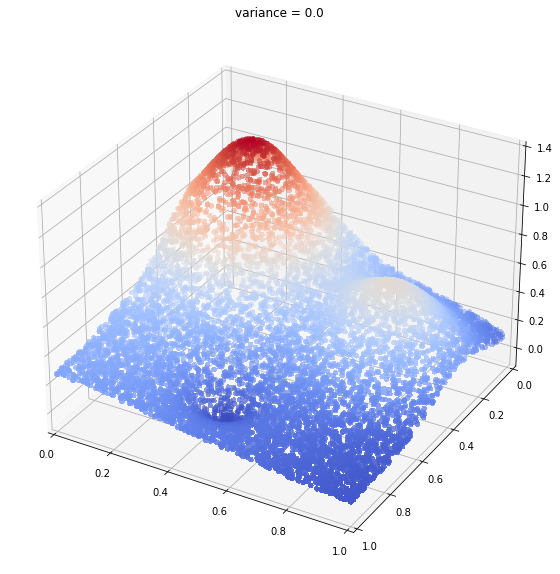

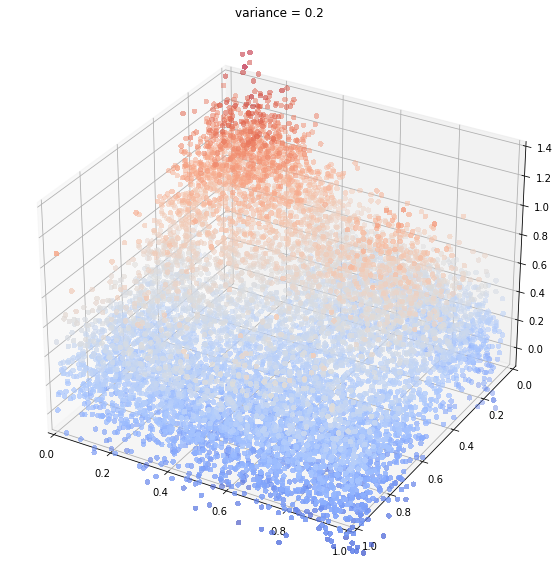

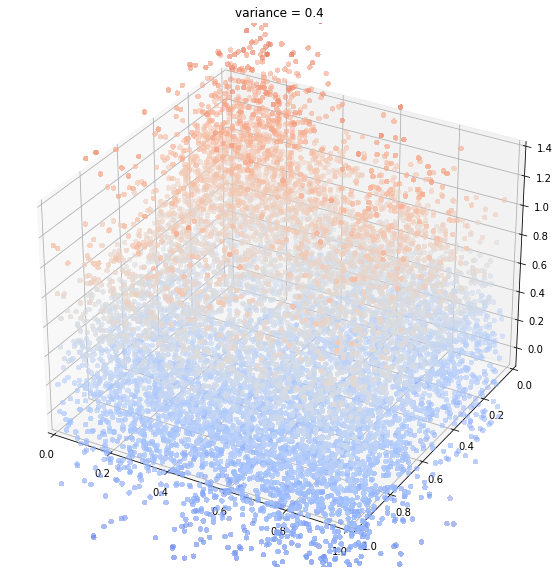

In [100]:
num_points = 10000
points = np.random.rand(num_points,2)
noise_v = np.arange(0,0.5,0.2)

for n in range(len(noise_v)):

    z = (FrankeFunction(points[:,0], points[:,1]) + np.random.normal(0,noise_v[n],[1,len(points)])).T
    fig = plt.figure(figsize=(10,10))
    ax = fig.gca(projection="3d")
    surf = ax.scatter(points[:,0],points[:,1], z, cmap=cm.coolwarm,c=z, linewidth=0, antialiased=False)
    ax.set_title("variance = " + str(noise_v[n]))
    ax.set_zlim(-0.10, 1.40)
    ax.set_xlim(0,1)
    ax.set_ylim(1,0)
    plt.show()

In [127]:
num_points = 100
poly = PolynomialFeatures(degree=3)
noise_v = np.arange(0,1,0.1)


# we set the intercept parameter as False because it is already considered in the first column of the data after the transformation with PolynomialFeatures
model = LinearRegression(fit_intercept=False)

train_mse = np.zeros(len(noise_v))
test_mse = np.zeros(len(noise_v))

# creating data and separating into training and test set
points = np.random.rand(num_points,2)
points_train, points_test= train_test_split(points, test_size=0.2)

for n in range(len(noise_v)):

    #function with added noise
    z_train = (FrankeFunction(points_train[:,0], points_train[:,1]) + np.random.normal(0,noise_v[n],[1,len(points_train)])).T
    z_test = (FrankeFunction(points_test[:,0], points_test[:,1]) + np.random.normal(0,noise_v[n],[1,len(points_test)])).T

    data_train = poly.fit_transform(points_train)
    data_test = poly.fit_transform(points_test)

    #fit the model
    model.fit(data_train,z_train)

    z_tilde = model.predict(data_train)
    z_predict = model.predict(data_test)

    # obtain the measures
    train_mse[n] = (mse(z_train,z_tilde))
    test_mse[n] = (mse(z_test,z_predict))

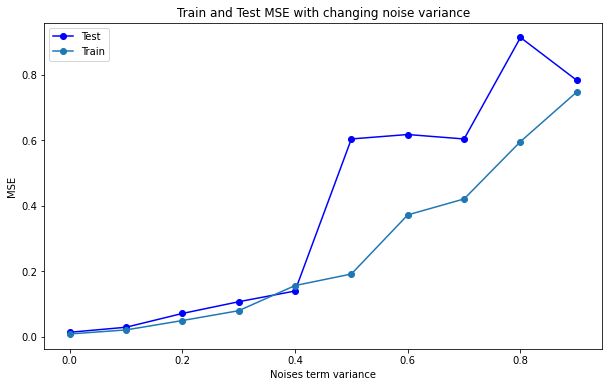

In [128]:
fig = plt.figure(figsize=(10,6))
plt.plot(noise_v,test_mse,"-o",color='b',label="Test")
plt.plot(noise_v,train_mse,"-o",label="Train")
plt.title("Train and Test MSE with changing noise variance")
plt.xlabel("Noises term variance")
plt.ylabel("MSE")
plt.legend()
plt.savefig('Train and Test MSE with changing noise variance')
plt.show()

### OLS on the Franke function

In [189]:
# generate the points and calculate the function
points, z = point_generator(100,0.1, rseed)
points_train, points_test, z_train, z_test = train_test_split(points, z, test_size=0.2)

In [190]:
# we consider the OLS on our data and consider changing degree between 1 and 5

max_deg = 5
beta_table = pd.DataFrame() #table to store the coefficients

# variables used to plot the approximated surfaces
# x = np.arange(1, 0, -0.05)
# y = np.arange(1, 0, -0.05)
# x, y = np.meshgrid(x,y)

model = LinearRegression(fit_intercept=False)

train_r2 = np.zeros(max_deg)
train_mse = np.zeros(max_deg)
test_r2 = np.zeros(max_deg)
test_mse = np.zeros(max_deg)

for deg in range(max_deg):

    poly = PolynomialFeatures(degree=deg+1)
    data_train = poly.fit_transform(points_train)
    data_test = poly.fit_transform(points_test)

    model.fit(data_train,z_train)

    beta_table = pd.concat([beta_table,pd.Series(list(model.coef_.T))],axis=1,ignore_index=True)

    z_tilde = model.predict(data_train)
    z_predict = model.predict(data_test)

    train_r2[deg] = (r2(z_train,z_tilde))
    train_mse[deg] = (mse(z_train,z_tilde))
    test_r2[deg] = (r2(z_test,z_predict))
    test_mse[deg] = (mse(z_test,z_predict))

    # code to plot the surfaces

    # fig = plt.figure(figsize=(10,10))
    # ax = fig.gca(projection="3d")
    # z = poly.fit_transform(np.vstack([x.ravel(), y.ravel()]).T) @ model.coef_.T
    # surf = ax.plot_surface(y,x, z.reshape(20,20), cmap=cm.coolwarm, linewidth=0, antialiased=False)
    # ax.set_title("deg = " + str(deg+1))
    # ax.set_zlim(-0.10, 1.40)
    # ax.set_xlim(0,1)
    # ax.set_ylim(1,0)
    # plt.show()

In [106]:
# showing the beta table

beta_table.fillna("", inplace=True)
beta_table.set_axis(['1','2','3','4','5'], axis=1, inplace=True)
beta_table

,1,2,3,4,5
0,[0.9632999455066078],[1.1553623558199762],[0.7444938361841928],[0.38514143520386035],[0.14931646213313976]
1,[-0.3994301066507594],[-1.237911078996102],[0.8324884294977534],[6.1134958823614065],[9.303818501333586]
2,[-0.704965437919818],[-0.5637786318583871],[2.5471157017406267],[4.128275559385469],[5.120943783430614]
3,,[0.23714798698904008],[-4.27136372773825],[-24.53489052322698],[-30.221098057653204]
4,,[1.1647860390887448],[0.494640408259777],[-5.138341272962147],[-21.695274499400636]
5,,[-0.621689881438606],[-8.634009395518527],[-14.47995129391097],[-12.704177484111225]
6,,,[2.534129975034925],[30.92936175972711],[10.810260587750069]
7,,,[1.6046116116635654],[14.490932175061412],[77.97410221596247]
8,,,[-0.893489782259546],[-0.5923434822445375],[14.532216582702052]
9,,,[5.635842751578787],[15.529264399123416],[2.004487960855293]


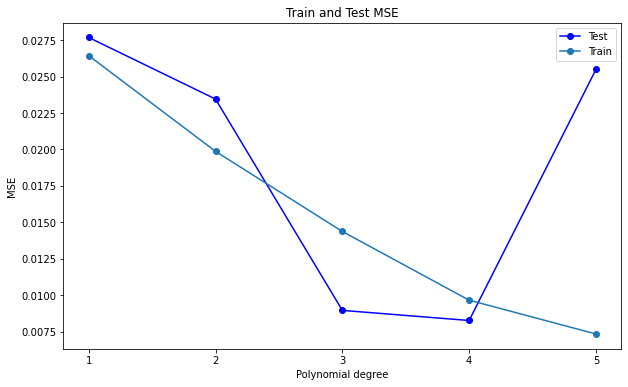

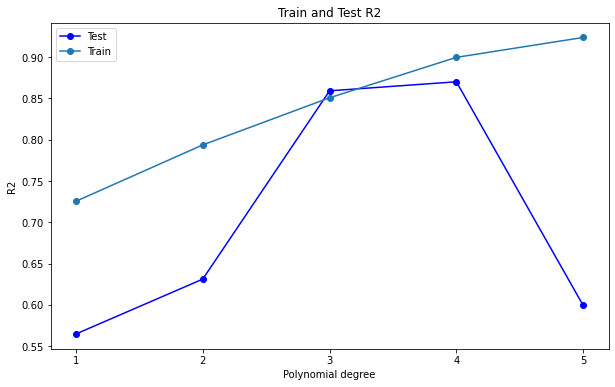

In [191]:
# showing the results for MSE and R2

fig = plt.figure(figsize=(10,6))
plt.plot(range(1,max_deg+1),test_mse,"-o",color='b',label="Test")
plt.plot(range(1,max_deg+1),train_mse,"-o",label="Train")
plt.title("Train and Test MSE")
plt.xlabel("Polynomial degree")
plt.xticks(range(1,max_deg+1))
plt.ylabel("MSE")
plt.legend()
plt.savefig('Train and Test MSE')
plt.show()

fig = plt.figure(figsize=(10,6))
plt.plot(range(1,max_deg+1),test_r2,"-o",color='b',label="Test")
plt.plot(range(1,max_deg+1),train_r2,"-o",label="Train")
plt.title("Train and Test R2")
plt.xlabel("Polynomial degree")
plt.xticks(range(1,max_deg+1))
plt.ylabel("R2")
plt.legend()
plt.savefig('Train and Test R2')
plt.show()

In [108]:
# code to obtain the heatmap describing the train mse for different degrees and number of points

max_deg = 10
model = LinearRegression(fit_intercept=False)
rseed = 1

num_points_v = np.arange(100,2100,200)
error_train = np.zeros([len(num_points_v),max_deg])

for deg in range(max_deg):
    for i in range(len(num_points_v)):

        points, z = point_generator(num_points_v[i],0.1,, rseed)

        poly = PolynomialFeatures(degree=deg+1)
        data = poly.fit_transform(points)

        data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)
        
        model.fit(data_train,z_train)
        z_tilde = model.predict(data_train)

        error_train[i][deg] = np.mean(np.mean((z_train - z_tilde)**2, axis=1, keepdims=True))

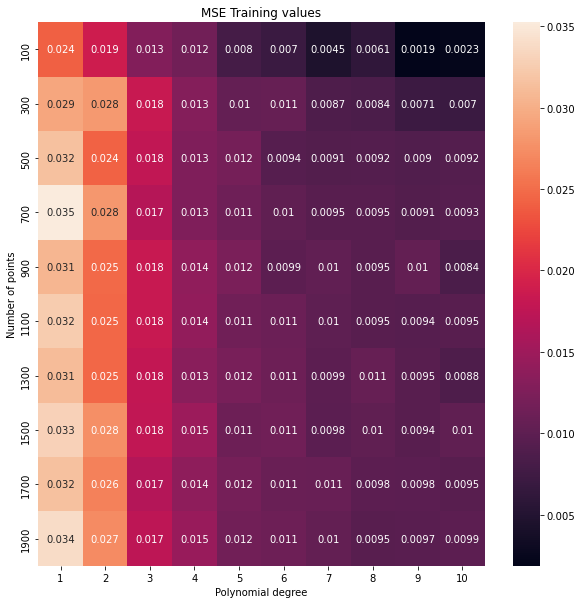

In [109]:
fig = plt.figure(figsize=(10,10))
sb.heatmap(error_train,vmin=np.amin(error_train),vmax=np.amax(error_train),annot=True,xticklabels=range(1,11),yticklabels=num_points_v)
plt.title("MSE Training values")
plt.ylabel("Number of points")
plt.xlabel("Polynomial degree")
plt.savefig("MSE training heatmap.png")

In [192]:
# studying the bias-variance tradeoff by implementing the bootstrap

n_boostraps = 80
max_deg = 5
error = np.zeros(max_deg)
bias = np.zeros(max_deg)
variance = np.zeros(max_deg)
model = LinearRegression(fit_intercept=False)

points, z = point_generator(100,0.1, rseed)

# changing the degree of the polynomia
for deg in range(max_deg):

    poly = PolynomialFeatures(degree=deg+1)
    data = poly.fit_transform(points)

    data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)
    z_pred = np.empty((len(z_test), n_boostraps))

    for i in range(n_boostraps):
        data_, z_ = resample(data_train, z_train)
        model.fit(data_,z_)
        z_pred[:,i] = np.squeeze(model.predict(data_test)).T

    error[deg], bias[deg], variance[deg] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

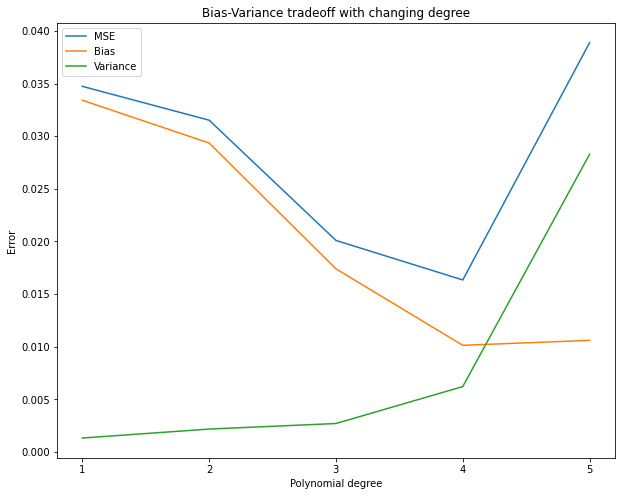

In [193]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,max_deg+1), error, label='MSE')
plt.plot(range(1,max_deg+1), bias, label='Bias')
plt.plot(range(1,max_deg+1), variance, label='Variance')
plt.title("Bias-Variance tradeoff with changing degree")
plt.xlabel("Polynomial degree")
plt.xticks(range(1,max_deg+1))
plt.ylabel("Error")
plt.legend()
plt.savefig('Bias-Variance tradeoff with changing degree')
plt.show()

In [152]:
# studying the bias-variance tradeoff by changing both the number of points and the degree

max_deg = 5
model = LinearRegression(fit_intercept=False)
rseed = 2

num_points_v = np.arange(50,200,20)
error = np.zeros([len(num_points_v),max_deg])
bias = np.zeros([len(num_points_v),max_deg])
variance = np.zeros([len(num_points_v),max_deg])


for deg in range(max_deg):
    for i in range(len(num_points_v)):

        n_boostraps = int(0.8*num_points_v[i])

        points, z = point_generator(num_points_v[i],0.1, rseed)
        poly = PolynomialFeatures(degree=deg+1)
        data = poly.fit_transform(points)

        data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2)

        error[i][deg], bias[i][deg], variance[i][deg] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

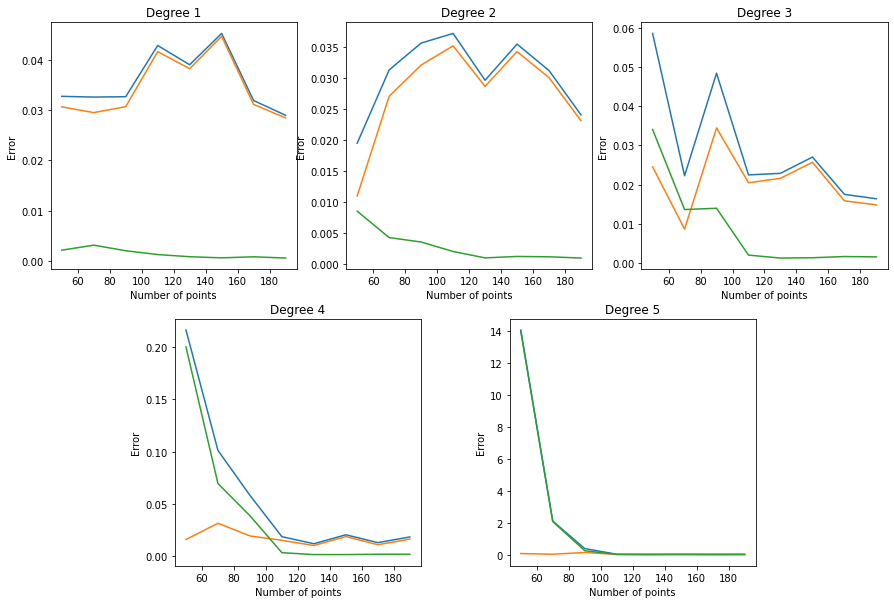

In [153]:
#plotting the results

fig, axes = plt.subplots(2,3, figsize=(15,10))
axes[1][2].set_visible(False)

axes[1][0].set_position([0.24,0.125,0.228,0.343])
axes[1][1].set_position([0.55,0.125,0.228,0.343])

axes[0][0].plot(num_points_v, error[:,0], label='Error')
axes[0][0].plot(num_points_v, bias[:,0], label='bias')
axes[0][0].plot(num_points_v, variance[:,0], label='Variance')
axes[0][0].set_title("Degree 1")
axes[0][0].set_xlabel("Number of points")
axes[0][0].set_ylabel("Error")

axes[0][1].plot(num_points_v, error[:,1], label='Error')
axes[0][1].plot(num_points_v, bias[:,1], label='bias')
axes[0][1].plot(num_points_v, variance[:,1], label='Variance')
axes[0][1].set_title("Degree 2")
axes[0][1].set_xlabel("Number of points")
axes[0][1].set_ylabel("Error")

axes[0][2].plot(num_points_v, error[:,2], label='Error')
axes[0][2].plot(num_points_v, bias[:,2], label='bias')
axes[0][2].plot(num_points_v, variance[:,2], label='Variance')
axes[0][2].set_title("Degree 3")
axes[0][2].set_xlabel("Number of points")
axes[0][2].set_ylabel("Error")

axes[1][0].plot(num_points_v, error[:,3], label='Error')
axes[1][0].plot(num_points_v, bias[:,3], label='bias')
axes[1][0].plot(num_points_v, variance[:,3], label='Variance')
axes[1][0].set_title("Degree 4")
axes[1][0].set_xlabel("Number of points")
axes[1][0].set_ylabel("Error")

axes[1][1].plot(num_points_v, error[:,4], label='Error')
axes[1][1].plot(num_points_v, bias[:,4], label='bias')
axes[1][1].plot(num_points_v, variance[:,4], label='Variance')
axes[1][1].set_title("Degree 5")
axes[1][1].set_xlabel("Number of points")
axes[1][1].set_ylabel("Error")

#plt.savefig('Bias-Variance tradeoff with changing degree and number of points.png')
plt.show()

### Resampling methods comparison

In [194]:
#comparing the error of CV and bootstrap

n_boostraps = 80
max_deg = 5

boot_error = np.zeros(max_deg)
cv_error5 = np.zeros(max_deg)
cv_error2 = np.zeros(max_deg)
model = LinearRegression(fit_intercept=False)

points, z = point_generator(100,0.1, 1024)

for deg in range(max_deg):

    poly = PolynomialFeatures(degree=deg+1)
    data = poly.fit_transform(points)

    cv_error5[deg] = cv_mse(data,z,5,model)
    cv_error2[deg] = cv_mse(data,z,2,model)

    data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2)
    boot_error[deg] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)[0]

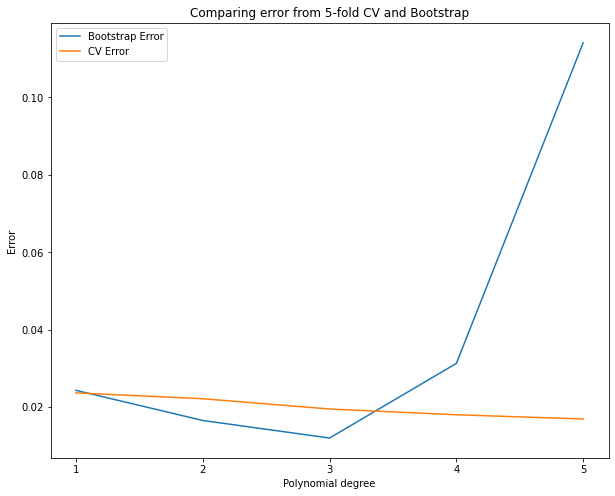

In [195]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,max_deg+1), boot_error, label='Bootstrap Error')
plt.plot(range(1,max_deg+1), cv_error5, label='CV Error')
plt.title("Comparing error from 5-fold CV and Bootstrap")
plt.xlabel("Polynomial degree")
plt.xticks(range(1,max_deg+1))
plt.ylabel("Error")
plt.legend()
plt.legend()
plt.savefig("Comparing error from 5-fold CV and Bootstrap")
plt.show()

In [197]:
# considering different numbers of folds

max_deg = 5
folds_v = range(5,11,1)
cv_error = np.zeros([max_deg,len(folds_v)])
model = LinearRegression()

for deg in range(max_deg):

    poly = PolynomialFeatures(degree=deg+1)
    data = poly.fit_transform(points)

    for i in range(len(folds_v)):
        cv_error[deg][i] = cv_mse(data,z,folds_v[i],model)

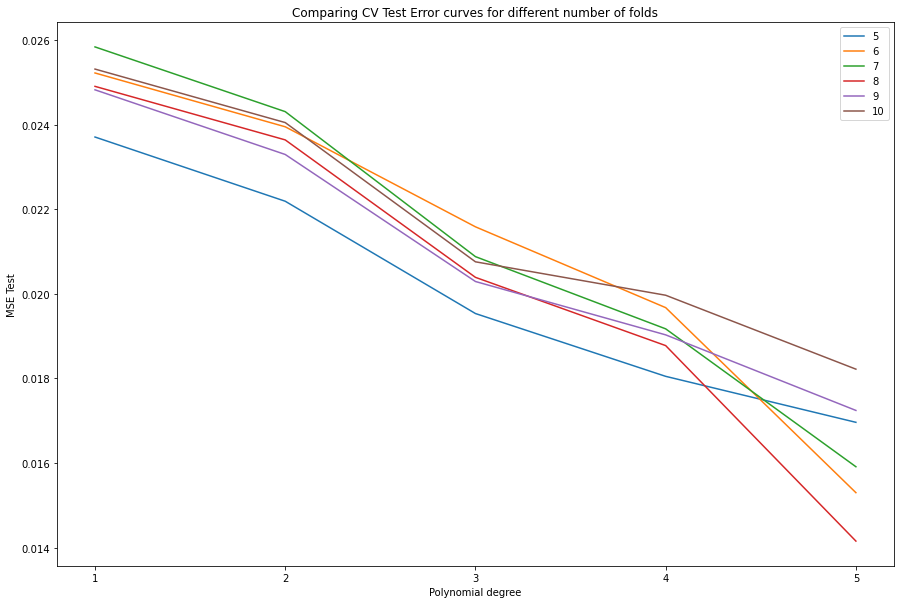

In [198]:
fig = plt.figure(figsize=(15,10))
for i in range(len(folds_v)):
    plt.plot(range(1,max_deg+1),cv_error[:,i],label=str(folds_v[i]))

plt.xticks(range(1,max_deg+1))
plt.legend()
plt.xlabel("Polynomial degree")
plt.ylabel("MSE Test")
plt.title("Comparing CV Test Error curves for different number of folds")
#plt.savefig("Comparing CV Test Error curves for different number of folds.png")
plt.show()

### Ridge Regression analysis

In [223]:
nlambdas = 100
lambdas = np.logspace(-5, 5, nlambdas)

poly = PolynomialFeatures(degree=3)
data = poly.fit_transform(points)
data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)

betas = np.zeros([nlambdas, 10])

for i in range(nlambdas):

    betas[i,:] = ridge_pred(data_train, data_test, z_train, lambdas[i])[1]

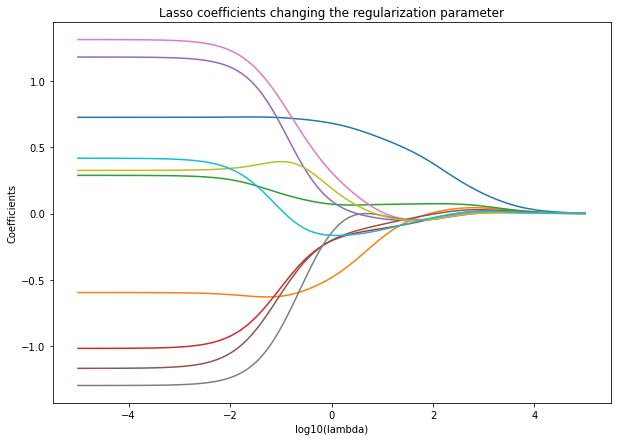

In [224]:
plt.figure(figsize=(10,7))
plt.plot(np.linspace(-5, 5, nlambdas),betas)

plt.xlabel('log10(lambda)')
plt.ylabel('Coefficients')
plt.title("Lasso coefficients changing the regularization parameter")
plt.savefig("Lasso coefficients changing the regularization parameter.png")
plt.show()

In [201]:
# bias-variance tradeoff with ridge

nlambdas = 8
lambdas = np.logspace(-5, 5, nlambdas)

## fare il bootstrap
n_boostraps = 80
max_deg = 5
error = np.zeros([nlambdas,max_deg])
bias = np.zeros([nlambdas,max_deg])
variance = np.zeros([nlambdas,max_deg])

#changing lambda
for i in range(nlambdas):
    model = Ridge(lambdas[i], fit_intercept=False)

# changing the degree of the polynomial
    for deg in range(max_deg):
        poly = PolynomialFeatures(degree=deg+1)
        data = poly.fit_transform(points)

        data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)

        error[i][deg], bias[i][deg], variance[i][deg] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

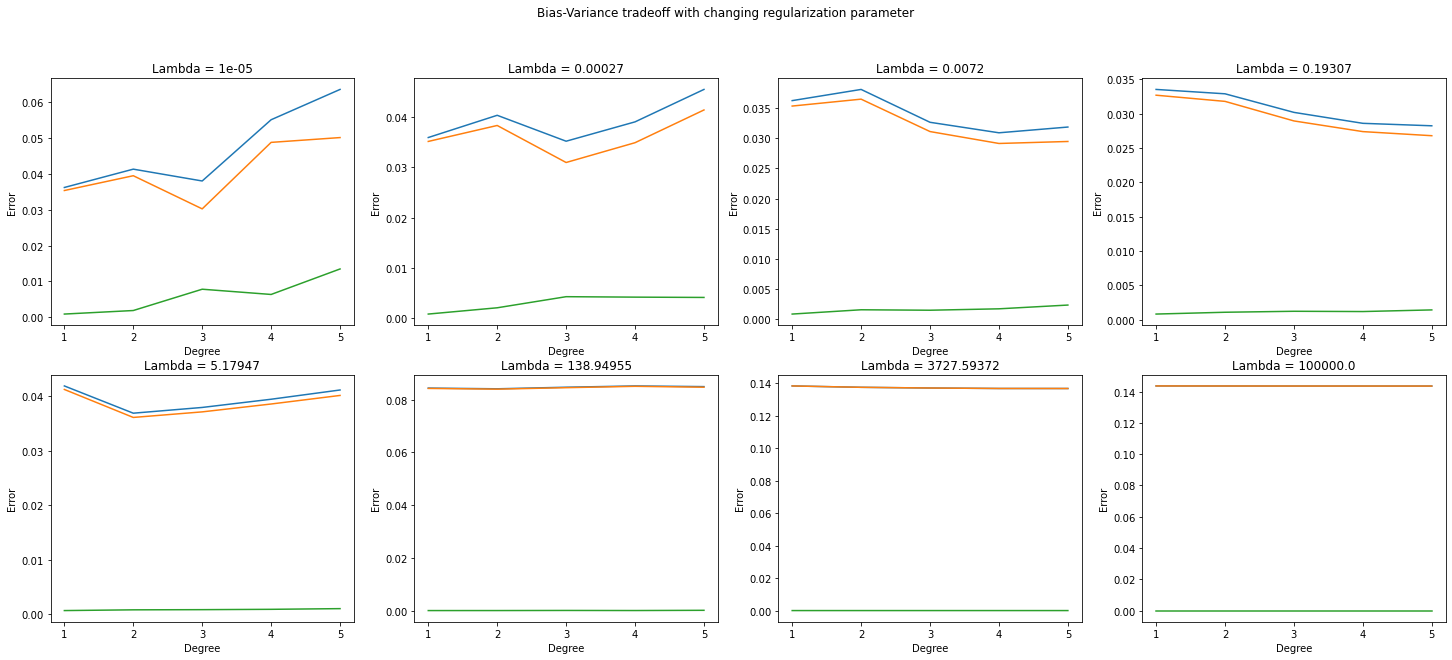

<Figure size 432x288 with 0 Axes>

In [202]:
fig, axes = plt.subplots(2,4, figsize=(25,10))

for i in range(nlambdas):
    ax = axes.ravel()[i]
    ax.plot(range(1,max_deg+1), error[i,:], label='Error')
    ax.plot(range(1,max_deg+1), bias[i,:], label='bias')
    ax.plot(range(1,max_deg+1), variance[i,:], label='Variance')
    ax.set_xticks(range(1,max_deg+1))
    ax.set_xlabel("Degree")
    ax.set_ylabel("Error")
    ax.set_title("Lambda = " + str(lambdas[i].round(5)))

fig.suptitle('Bias-Variance tradeoff with changing regularization parameter')
plt.show()
plt.savefig("Bias-Variance tradeoff with changing regularization parameter")

### Lasso Regression analysis

In [53]:
# lasso analysis

poly = PolynomialFeatures(degree=3)
data = poly.fit_transform(points)
data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)

nlambdas = 100
lambdas = np.logspace(-10, 2.5, nlambdas)
betas = [[] for i in range(nlambdas)]

for i in range(nlambdas):
    model = Lasso(lambdas[i], fit_intercept=False).fit(data_train,z_train)
    betas[i] = model.coef_

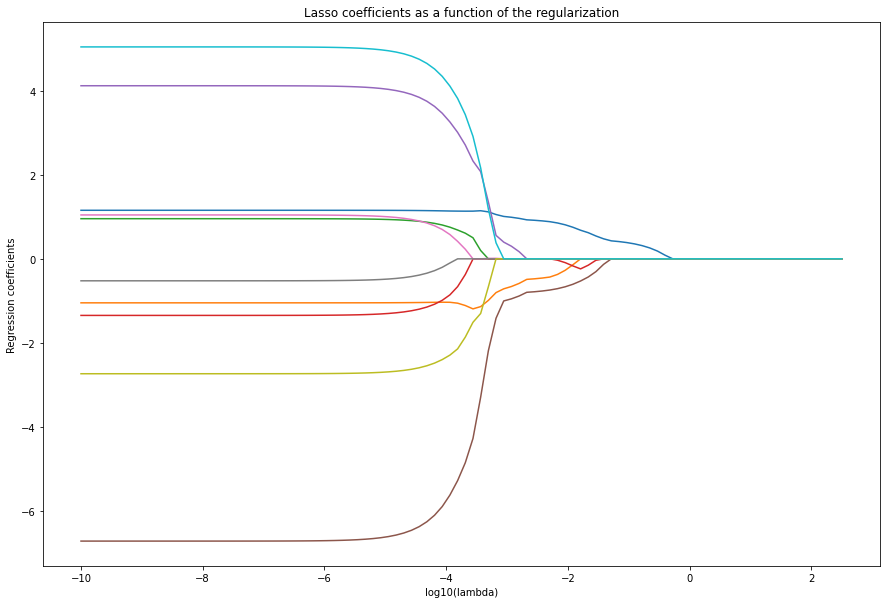

In [54]:
plt.figure(figsize=(15,10))
plt.plot(np.log10(lambdas), betas)
plt.xlabel('log10(lambda)')
plt.ylabel('Regression coefficients')
plt.title("Lasso coefficients as a function of the regularization")
plt.savefig("Lasso coefficients as a function of the regularization")
plt.show()

In [203]:
# bias-variance tradeoff with lasso
nlambdas = 8
lambdas = np.logspace(-5, 0, nlambdas)

## fare il bootstrap
n_boostraps = 80
max_deg = 5
error = np.zeros([nlambdas,max_deg])
bias = np.zeros([nlambdas,max_deg])
variance = np.zeros([nlambdas,max_deg])

#changing lambda
for i in range(nlambdas):
    model = Lasso(lambdas[i], fit_intercept=False)
    
# changing the degree of the polynomia
    for deg in range(max_deg):
        poly = PolynomialFeatures(degree=deg+1)
        data = poly.fit_transform(points)

        data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2)
        error[i][deg], bias[i][deg], variance[i][deg] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

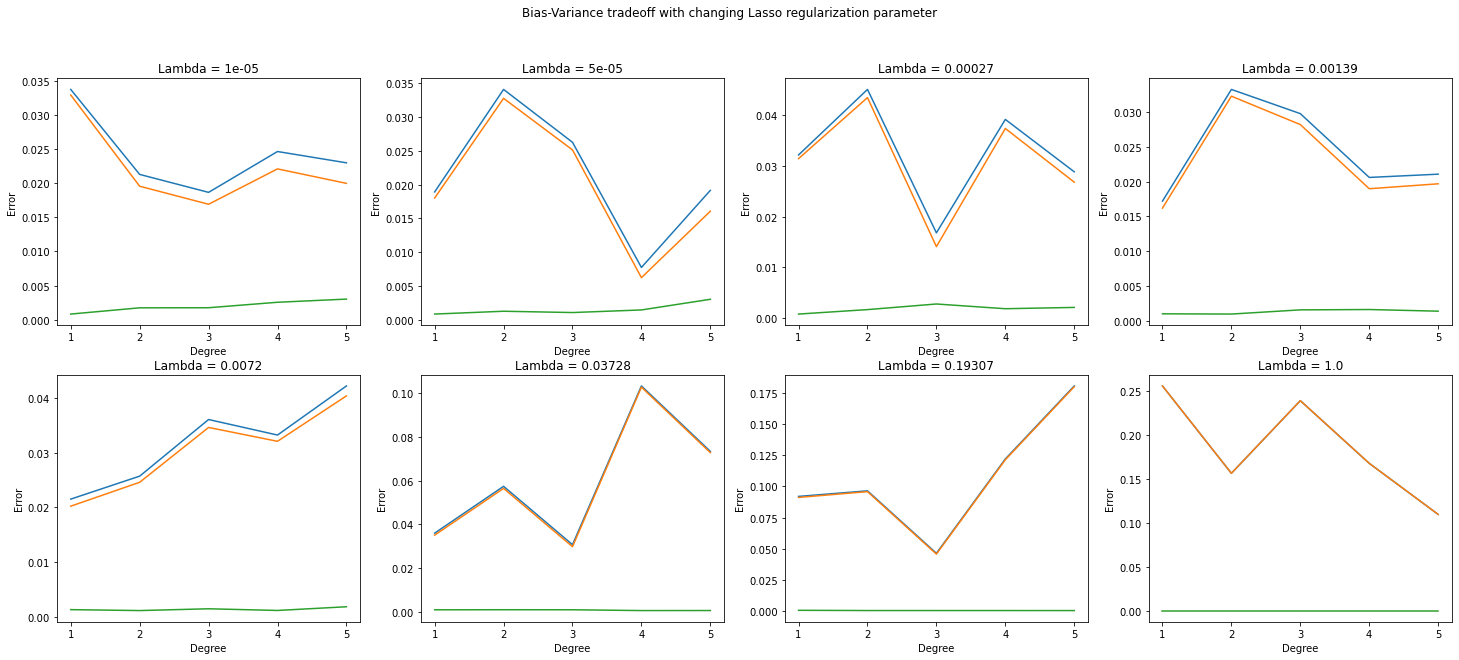

In [204]:
fig, axes = plt.subplots(2,4, figsize=(25,10))

for i in range(nlambdas):
    ax = axes.ravel()[i]
    ax.plot(range(1,max_deg+1), error[i,:], label='Error')
    ax.plot(range(1,max_deg+1), bias[i,:], label='bias')
    ax.plot(range(1,max_deg+1), variance[i,:], label='Variance')
    ax.set_xticks(range(1,max_deg+1))
    ax.set_xlabel("Degree")
    ax.set_ylabel("Error")
    ax.set_title("Lambda = " + str(lambdas[i].round(5)))

fig.suptitle('Bias-Variance tradeoff with changing Lasso regularization parameter ')
plt.savefig("Bias-Variance tradeoff with changing Lasso regularization parameter.png")
plt.show()


### Comparison

In [205]:
# comparison between the 3 methods using CV

n_folds = 10

poly = PolynomialFeatures(degree=3)
data = poly.fit_transform(points)

ols_MSE = cv_mse(data,z,n_folds,LinearRegression(fit_intercept=False))

nlambdas = 100
lambdas = np.logspace(-5, 5, nlambdas)

ridge_MSE = np.zeros(nlambdas)
lasso_MSE = np.zeros(nlambdas)

for i in range(nlambdas):
    ridge_MSE[i] = cv_mse(data,z,n_folds,Ridge(lambdas[i], fit_intercept=False))
    lasso_MSE[i] = cv_mse(data,z,n_folds,Lasso(lambdas[i], fit_intercept=False))

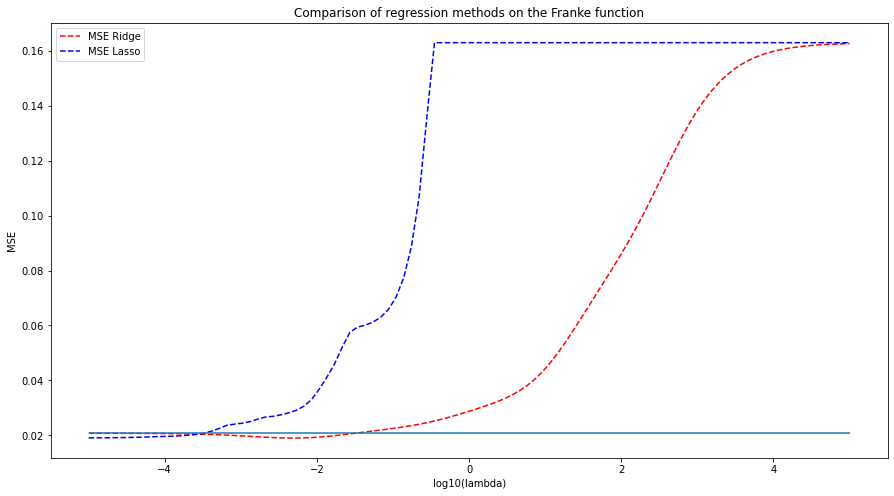

In [206]:
plt.figure(figsize=(15,8))
plt.plot(np.log10(lambdas), ridge_MSE, 'r--', label = 'MSE Ridge')
plt.plot(np.log10(lambdas), lasso_MSE, 'b--', label = 'MSE Lasso')
plt.hlines(ols_MSE,-5,5)
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Comparison of regression methods on the Franke function')
plt.legend()
plt.savefig("Comparison of regression methods on the Franke function.png")
plt.show()

In [208]:
# comparison between the 3 methods using CV

n_folds = 10
points, z = point_generator(100,0.5, rseed)

poly = PolynomialFeatures(degree=3)
data = poly.fit_transform(points)

ols_MSE = cv_mse(data,z,n_folds,LinearRegression(fit_intercept=False))

nlambdas = 100
lambdas = np.logspace(-5, 5, nlambdas)

ridge_MSE = np.zeros(nlambdas)
lasso_MSE = np.zeros(nlambdas)

for i in range(nlambdas):
    ridge_MSE[i] = cv_mse(data,z,n_folds,Ridge(lambdas[i], fit_intercept=False))
    lasso_MSE[i] = cv_mse(data,z,n_folds,Lasso(lambdas[i], fit_intercept=False))

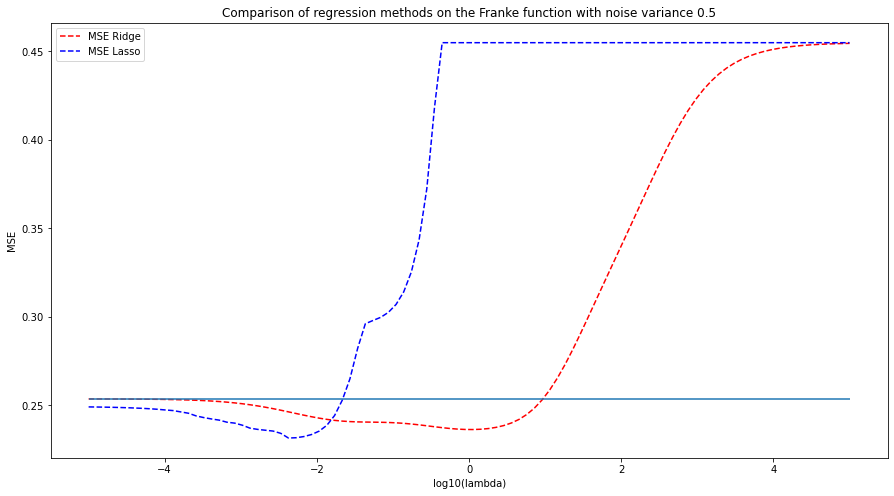

In [209]:
plt.figure(figsize=(15,8))
plt.plot(np.log10(lambdas), ridge_MSE, 'r--', label = 'MSE Ridge')
plt.plot(np.log10(lambdas), lasso_MSE, 'b--', label = 'MSE Lasso')
plt.hlines(ols_MSE,-5,5)
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Comparison of regression methods on the Franke function with noise variance 0.5')
plt.legend()
plt.savefig("Comparison of regression methods on the Franke function with noise variance 0.5.png")
plt.show()

## Terrain data

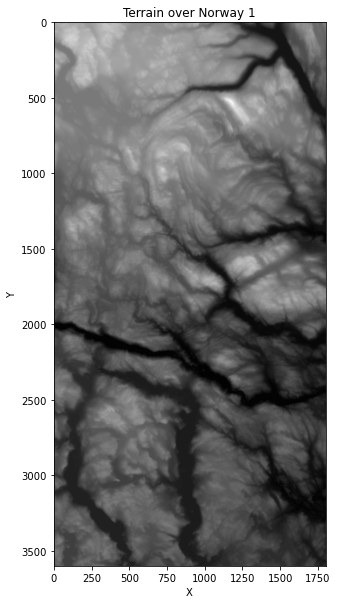

In [72]:
# Load the terrain
terrain = imread("SRTM_data_Norway_1.tif")
# Show the terrain 2d plot
plt.figure(figsize=(15,10))
plt.title("Terrain over Norway 1")
plt.imshow(terrain, cmap="gray")
plt.xlabel("X")
plt.ylabel("Y")
plt.savefig("Terrain data.png")
plt.show()

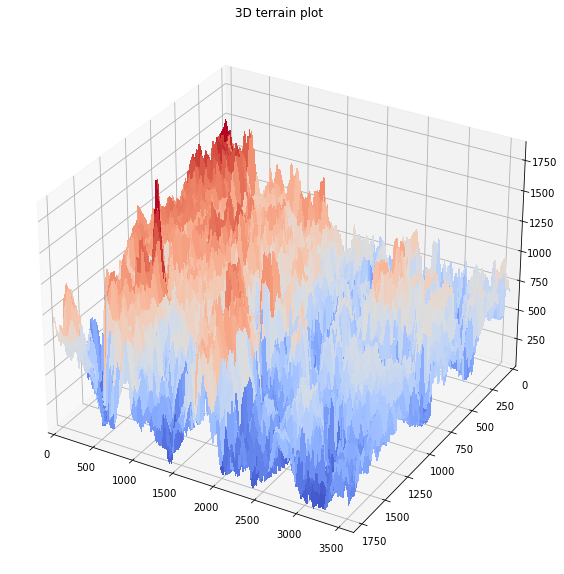

In [80]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")
x,y = np.meshgrid(range(3601), range(1801))
surf = ax.plot_surface(x.T,y.T, terrain, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.set_xlim(0,3601)
ax.set_ylim(1801,0)
plt.title("3D terrain plot")
plt.savefig("3D terrain plot.png")
plt.show()

In [210]:
npoints = 1000
points = np.zeros([npoints,2])
z = np.zeros([npoints,1])
points[:,0] = np.random.randint(np.shape(terrain)[0],size=npoints)
points[:,1] = np.random.randint(np.shape(terrain)[1],size=npoints)

for i in range(npoints):
    z[i] = terrain[int(points[i,0])][int(points[i,1])]

z = min_max_scaling(z)
points[:,0] = min_max_scaling(points[:,0])
points[:,1] = min_max_scaling(points[:,1])

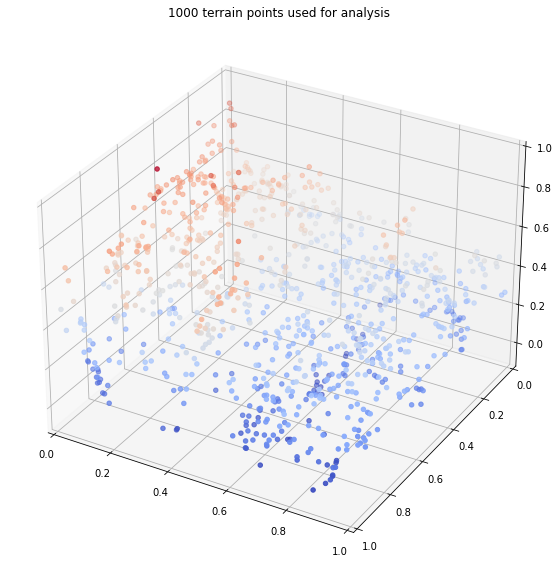

In [211]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection="3d")
x,y = np.meshgrid(range(3601), range(1801))
#surf = ax.plot_surface(x.T,y.T, terrain, cmap=cm.coolwarm,linewidth=0, antialiased=False)
ax.scatter(points[:,0],points[:,1],z,cmap=cm.coolwarm, c=z)
ax.set_zlim(-0.10, 1)
ax.set_xlim(0,1)
ax.set_ylim(1,0)
plt.title("1000 terrain points used for analysis")
plt.savefig("1000 terrain points used for analysis.png")
plt.show()

In [212]:
max_deg = 14

train_r2 = np.zeros(max_deg)
train_mse = np.zeros(max_deg)
test_r2 = np.zeros(max_deg)
test_mse = np.zeros(max_deg)

model = LinearRegression(fit_intercept=False)

for deg in range(max_deg):
    
        poly = PolynomialFeatures(degree=deg+1)
        data = poly.fit_transform(points)
        data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2)

        model.fit(data_train,z_train)

        z_tilde = model.predict(data_train)
        z_predict = model.predict(data_test)

        train_mse[deg] = (mse(z_train,z_tilde))
        test_mse[deg] = (mse(z_test,z_predict))

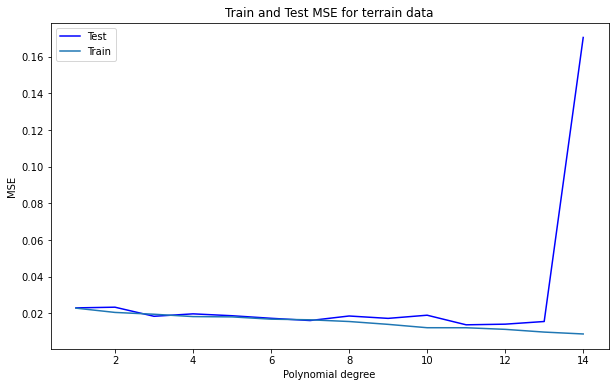

In [213]:
fig = plt.figure(figsize=(10,6))
plt.plot(range(1,max_deg+1),test_mse,color='b',label="Test")
plt.plot(range(1,max_deg+1),train_mse,label="Train")
plt.title("Train and Test MSE for terrain data")
plt.xlabel("Polynomial degree")
plt.ylabel("MSE")
plt.legend()
#plt.savefig("Train and Test MSE for terrain data.png")
plt.show()

In [214]:
# comparison between the 3 methods on terrain data

n_folds = 10

poly = PolynomialFeatures(degree=13)
data = poly.fit_transform(points)

ols_MSE = cv_mse(data,z,n_folds,LinearRegression(fit_intercept=False))

nlambdas = 100
lambdas = np.logspace(-5, 5, nlambdas)

ridge_MSE = np.zeros(nlambdas)
lasso_MSE = np.zeros(nlambdas)

for i in range(nlambdas):
    ridge_MSE[i] = cv_mse(data,z,n_folds,Ridge(lambdas[i], fit_intercept=False))
    lasso_MSE[i] = cv_mse(data,z,n_folds,Lasso(lambdas[i], fit_intercept=False))

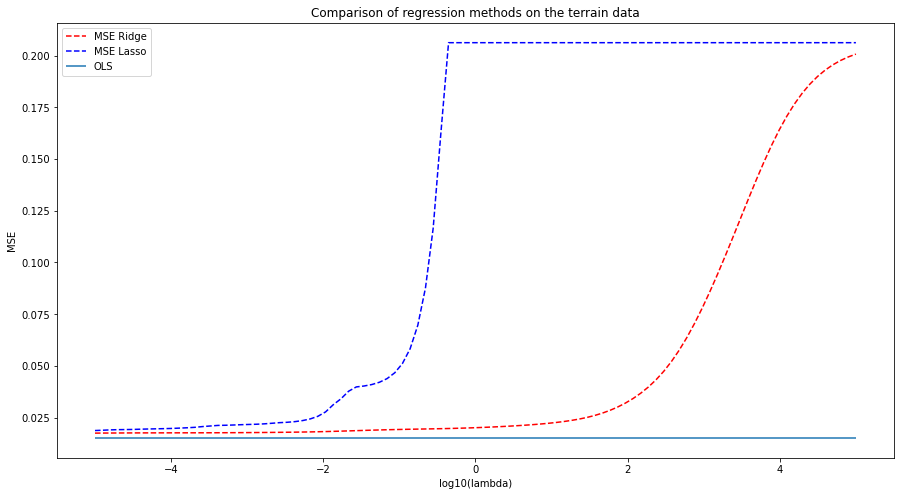

In [215]:
plt.figure(figsize=(15,8))
plt.plot(np.log10(lambdas), ridge_MSE, 'r--', label = 'MSE Ridge')
plt.plot(np.log10(lambdas), lasso_MSE, 'b--', label = 'MSE Lasso')
plt.hlines(ols_MSE,-5,5, label='OLS')
plt.xlabel('log10(lambda)')
plt.ylabel('MSE')
plt.title('Comparison of regression methods on the terrain data')
plt.legend()
plt.savefig("Comparison of regression methods on the terrain data.png")
plt.show()

In [216]:
# obtaining the bias-variance decomposition on terrain data

n_boostraps = 800
max_deg = 14
error = np.zeros(max_deg)
bias = np.zeros(max_deg)
variance = np.zeros(max_deg)
model = LinearRegression()

for deg in range(max_deg):
    poly = PolynomialFeatures(degree=deg+1)
    data = poly.fit_transform(points)

    data_train, data_test, z_train, z_test = train_test_split(data, z, test_size=0.2,random_state=rseed)
    error[deg], bias[deg], variance[deg] = bootstrap_bias_variance_decomposition(data_train, data_test, z_train, z_test, model, n_boostraps)

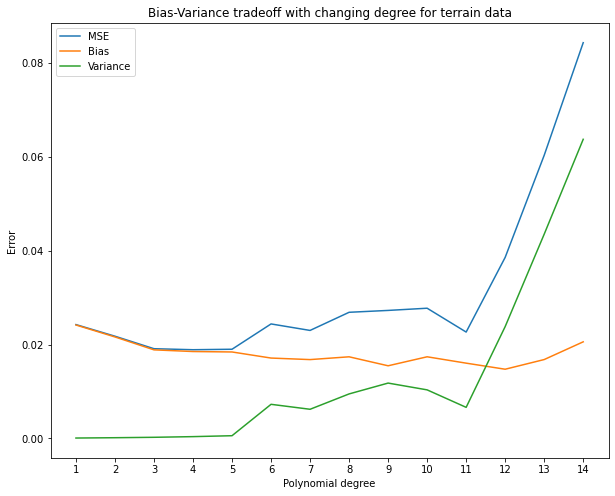

In [217]:
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,max_deg+1), error, label='MSE')
plt.plot(range(1,max_deg+1), bias, label='Bias')
plt.plot(range(1,max_deg+1), variance, label='Variance')
plt.title("Bias-Variance tradeoff with changing degree for terrain data")
plt.xlabel("Polynomial degree")
plt.xticks(range(1,max_deg+1))
plt.ylabel("Error")
plt.legend()
plt.savefig('Bias-Variance tradeoff with changing degree for terrain data')
plt.show()